<a href="https://colab.research.google.com/github/avvnessa/Fake-News-Detection/blob/main/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DETECÇÃO DE FAKE NEWS UTILIZANDO O ALGORITMO NAIVE BAYES**

#Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import io

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import string

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
uploaded = files.upload()

Saving fake_or_real_news.csv to fake_or_real_news.csv


In [ ]:
# Dataset do Kaggle https://www.kaggle.com/hassanamin/textdb3

df = pd.read_csv(io.BytesIO(uploaded['fake_or_real_news.csv']))

In [ ]:
print(df.shape)
print('\n')
print(df.info())
print('\n')
df.head()

(6335, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None




,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [ ]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

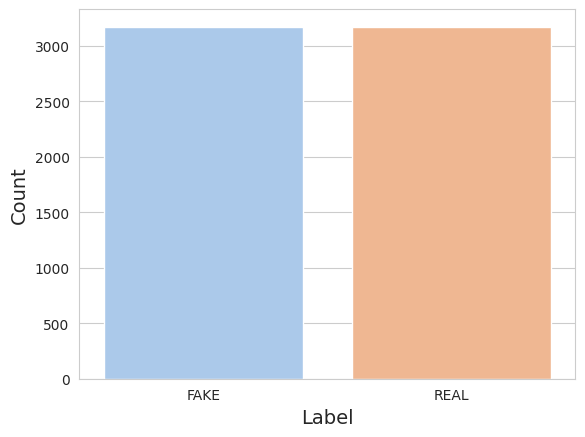

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='label', data=df, palette='pastel')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

##Pré-processamento

In [ ]:
df.columns = ['ID#', 'Title', 'Text', 'Label']

df = df.replace('FAKE', 0)
df = df.replace('REAL',1)

df['Text'] = df['Title'] + ' ' + df['Text']
df.head()

,ID#,Title,Text,Label
0,8476,You Can Smell Hillary’s Fear,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,3608,Kerry to go to Paris in gesture of sympathy,Kerry to go to Paris in gesture of sympathy U....,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters on Twitter erupt in anger ag...,0
4,875,The Battle of New York: Why This Primary Matters,The Battle of New York: Why This Primary Matte...,1


In [ ]:
news = df.drop(['ID#','Title'], axis=1)
news.head()

,Text,Label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy U....,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matte...,1


In [ ]:
# Letras minusculas, remover [], links, palavras que tenham numeros e pontuações
def clean_text(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?;//\S+|www\,\,\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text
news['Text'] = news['Text'].apply(lambda x:clean_text(x))

news.head()

,Text,Label
0,you can smell hillary’s fear daniel greenfield...,0
1,watch the exact moment paul ryan committed pol...,0
2,kerry to go to paris in gesture of sympathy us...,1
3,bernie supporters on twitter erupt in anger ag...,0
4,the battle of new york why this primary matter...,1


In [ ]:
# Remover stop words

stop = stopwords.words('english')
news['Text'] = news['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

news.head()

,Text,Label
0,smell hillary’s fear daniel greenfield shillma...,0
1,watch exact moment paul ryan committed politic...,0
2,kerry go paris gesture sympathy us secretary s...,1
3,bernie supporters twitter erupt anger dnc trie...,0
4,battle new york primary matters primary day ne...,1


In [ ]:
# Lemmatize (Deixa apenas a raiz das palavras)

def lemmatize_words(text):
  wnl = nltk.stem.WordNetLemmatizer()
  lem = ' '.join([wnl.lemmatize(word) for word in text.split()])
  return lem 

news['Text'] = news['Text'].apply(lemmatize_words)

news.head()

,Text,Label
0,smell hillary’s fear daniel greenfield shillma...,0
1,watch exact moment paul ryan committed politic...,0
2,kerry go paris gesture sympathy u secretary st...,1
3,bernie supporter twitter erupt anger dnc tried...,0
4,battle new york primary matter primary day new...,1


## Mineração de Dados

In [ ]:
# Dividir o Dataset em Treino e Teste

X_train, X_test, y_train, y_test = train_test_split(news['Text'],
                                                    news['Label'], test_size=0.25)
display(X_train.head())
print('\n')
display(y_train.head())

print("\nThere are {} documents in the training data.".format(len(X_train)))

6253    investment strategist forecast collapse timeli...
3309    house approves syrian refugee bill top dems wa...
4906    boehner israel trip planned netanyahuobama rif...
4667    use nonviolence nuke baker explosion part oper...
10      three clinton iowa glimpse fire eluded hillary...
Name: Text, dtype: object

6253    0
3309    1
4906    1
4667    0
10      1
Name: Label, dtype: int64


There are 4751 documents in the training data.


In [ ]:
#Extração de Features

my_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train = my_tfidf.fit_transform(X_train)
tfidf_test = my_tfidf.transform(X_test)

tfidf_train

<4751x93283 sparse matrix of type '<class 'numpy.float64'>'
	with 1182161 stored elements in Compressed Sparse Row format>

In [ ]:
#Aplicação do Naive Bayes

nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

pred1 = nb_classifier.predict(tfidf_test)

## Pós-processamento

In [ ]:
#Métricas do Algoritmo

print(classification_report(y_test, pred1, target_names= ['Fake', 'True']))

acc_score = accuracy_score(y_test, pred1)

conf_mat = confusion_matrix(y_test, pred1)

print(acc_score)
print('\n')
print(conf_mat)

              precision    recall  f1-score   support

        Fake       0.97      0.71      0.82       795
        True       0.77      0.98      0.86       789

    accuracy                           0.84      1584
   macro avg       0.87      0.84      0.84      1584
weighted avg       0.87      0.84      0.84      1584

0.8428030303030303


[[565 230]
 [ 19 770]]


In [ ]:
df1 = pd.DataFrame(X_test)
df1['Valor_Real'] = pd.DataFrame(y_test)
df1['Valor_Previsto'] = pred1

display(df1.head())

Falso_Negativo = df1[(df1.Valor_Real == 0) & (df1.Valor_Previsto == 1)]
Falso_Positivo = df1[(df1.Valor_Real == 1) & (df1.Valor_Previsto == 0)]

display(Falso_Negativo.head())
print('\n')
display(Falso_Positivo.head())

,Text,Valor_Real,Valor_Previsto
1243,shedevil patrick j buchanan october donald tru...,0,1
890,trump make “secret deal prosecute hillary” exc...,0,1
5187,republican blast kerry suggesting iran could s...,1,1
4412,fine give gop four year liberal case either be...,1,1
1877,small price million could beautiful selfsuffic...,0,0


,Text,Valor_Real,Valor_Previsto
1243,shedevil patrick j buchanan october donald tru...,0,1
890,trump make “secret deal prosecute hillary” exc...,0,1
4023,splc’s libelous new report antimuslim extremis...,0,1
6121,eamon dunphy george hook enter hour ‘who’s con...,0,1
2788,hope best prepare worst…,0,1


,Text,Valor_Real,Valor_Previsto
3124,clinton camp damagecontrol mode top secret ema...,1,0
5556,source u official warned dnc hack month party ...,1,0
3357,playing “rigged” card trump jones conspiracy m...,1,0
2204,campus rape really epidemic documentary campus...,1,0
3733,thanksgiving lesson syrian refugee debate pari...,1,0


> DETECÇÃO DE FAKE NEWS UTILIZANDO O ALGORITMO NAIVE BAYES. poƌ Rodrigo Cardoso Durgieǁicz